In [ ]:
%matplotlib inline

from copy import deepcopy
from dataclasses import asdict, dataclass, field
from typing import Literal, Mapping

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import xarray as xr

from IPython.display import clear_output, display

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#from google.colab import drive
#drive.mount('/content/drive')

from pathlib import Path
#dirpath_root = Path('/content/drive/MyDrive/repo/pytorch_test')
dirpath_root = Path().resolve()

cpu


#### DataSet

In [100]:
class DataSet:
    vars: dict
    state: Literal['np', 'torch']
    device: str

    def __init__(self,
                 vars: dict = None,
                 state: Literal['np', 'torch'] = 'np',
                 device: str = ''):
        self.vars = vars or {}
        self.state = state
        self.device = device
    
    def __getitem__(self, key):
        return self.vars[key]
    def __setitem__(self, key, value):
        self.vars[key] = value
    def __len__(self):
        return len(self.vars)
    def __iter__(self):
        return iter(self.vars)
    
    def plot(self,
             xvar: str = 'x', yvar: str = 'y',
             cvar: str | None = None, **kwargs):
        x = self.vars[xvar]
        y = self.vars[yvar]
        if cvar is not None:
            c = np.asarray(self.vars[cvar])
            colors = ['b', 'r', 'g', 'm', 'k']
            c = np.array(colors)[c % len(colors)]
        else:
            c = 'k'
        plt.scatter(x, y, c=c, **kwargs)
    
    def to_torch(self, device: str) -> 'DataSet':
        if self.state != 'np':
            raise ValueError('to_torch(): DataSet is not in numpy state')
        ds = DataSet(state='torch', device=device)
        for v, x in self.vars.items():
            ds[v] = torch.from_numpy(x).float()
        return ds
    
    def to_numpy(self) -> 'DataSet':
        if self.state != 'torch':
            raise ValueError('to_numpy(): DataSet is not in torch state')
        ds = DataSet(state='np')
        for v, x in self.vars.items():
            ds[v] = x.cpu().numpy().squeeze()
        return ds
    
    def unsqueeze(self, dim: int,
                  vars: list[str] | None = None) -> 'DataSet':
        if self.state != 'torch':
            raise ValueError('unsqueeze(): DataSet is not in torch state')
        if vars is None:
            vars = list(self.vars.keys())
        ds = DataSet(state='torch', device=device)
        for v in vars:
            ds[v] = self.vars[v].unsqueeze(dim)
        return ds

#### Multi-branch data generator

In [101]:
def plot_variable_line(x, y, color='blue', alpha=None, ax=None, linewidth=2, mode='opacity'):
    """
    Plot a line with per-segment styling driven by `alpha`.

    mode:
      - 'opacity'      -> alpha controls transparency (0 = fully transparent).
      - 'blend_white'  -> alpha blends color -> white (opaque paint).
    """
    x = np.ravel(np.asarray(x))
    y = np.ravel(np.asarray(y))
    if x.shape != y.shape:
        raise ValueError(f"x and y must have same shape, got {x.shape} vs {y.shape}")

    if alpha is None:
        alpha = np.ones_like(x, dtype=float)
    else:
        alpha = np.asarray(alpha, dtype=float)
        if alpha.ndim == 0:
            alpha = np.full_like(x, float(alpha))
        elif alpha.shape != x.shape:
            raise ValueError(f"alpha must be scalar or same shape as x, got {alpha.shape}")
    alpha = np.clip(alpha, 0, 1)

    # Build segments
    points = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    a = alpha[:-1]  # one value per segment

    base_rgb = np.array(mcolors.to_rgb(color))
    colors = np.empty((len(segments), 4), float)

    if mode == 'opacity':
        # Keep RGB constant; vary only alpha channel (true transparency)
        colors[:, :3] = base_rgb
        colors[:, 3] = a
    elif mode == 'blend_white':
        # Previous behavior: blend toward white, opaque paint
        colors[:, :3] = (1 - a)[:, None] * 1.0 + a[:, None] * base_rgb
        colors[:, 3] = 1.0
    else:
        raise ValueError("mode must be 'opacity' or 'blend_white'")

    lc = LineCollection(segments, colors=colors, linewidth=linewidth)
    ax = ax or plt.gca()
    ax.add_collection(lc)
    ax.autoscale()
    return lc

def test_plot_variable_line():
    x = np.linspace(0, 3, 200)
    y = np.sin(x)
    p = 1 / x
    plt.figure()
    plot_variable_line(x, y, 'b', alpha=p)
#test_plot_variable_line()

In [102]:
def weighted_counts(weights, total, min_each=0):
    """Integer allocate `total` across weights using largest remainder.
       If min_each>0, give at least that many to branches with w>0."""
    w = np.asarray(weights, dtype=float)
    if (w < 0).any():
        raise ValueError("weights must be nonnegative")
    if w.sum() == 0:
        w[:] = 1.0  # fallback to uniform

    # Reserve minima
    mins = np.where(w > 0, int(min_each), 0)
    left = total - mins.sum()
    if left < 0:
        raise ValueError("min_each too large for total")

    # Proportional part + largest remainder
    raw = w / w.sum() * left
    base = np.floor(raw).astype(int)
    rem = left - base.sum()
    if rem > 0:
        frac = raw - base
        idx = np.argsort(frac)[::-1][:rem]
        base[idx] += 1

    return base + mins

In [103]:
def sample_with_pdf(npts, xlim, p):
    ngen = 0
    x = []
    nbatch = npts
    while ngen < npts:
        x_ = np.random.uniform(xlim[0], xlim[1], nbatch)
        r_ = np.random.uniform(0, 1, nbatch)
        x_ = x_[r_ < p(x_)]
        x.append(x_)
        ngen += len(x_)
    x = np.concatenate(x)[:npts]
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def make_func(f_type: str, par: dict):
    par = deepcopy(par)
    if f_type == 'const':
        f = lambda x: np.full_like(np.asarray(x), par['c'], dtype=float)
    elif f_type == 'sigmoid':
        f = lambda x: par['c'] + par['a'] * sigmoid(par['k'] * (np.asarray(x) - par['x0']))
    else:
        raise ValueError(f'Unknown function type: {f_type}')
    
    xmin = par['xmin'] if 'xmin' in par else -np.inf
    xmax = par['xmax'] if 'xmax' in par else np.inf
    return lambda x: f(x) * ((np.asarray(x) >= xmin) & (np.asarray(x) <= xmax))
    

@dataclass
class Branch:
    px_type: str
    px_par: dict
    fy_type: str
    fy_par: dict
    weight: float = 1.0

    def generate_points(self, npts: int):
        fp = make_func(self.px_type, self.px_par)
        xlim = self.px_par['xmin'], self.px_par['xmax']
        x = sample_with_pdf(npts, xlim, fp)
        fy = make_func(self.fy_type, self.fy_par)
        y = fy(x)
        return x, y


class MultiBranchGenerator:
    branches: list[Branch]
    
    def __init__(self):
        self.branches = []

    def add_branch(self, *args, **kwargs):
        self.branches.append(Branch(*args, **kwargs))

    def generate_points(self, npts: int) -> DataSet:
        # Num. points in each branch
        weights = [getattr(br, 'weight', 1.0) for br in self.branches]
        npts_br = weighted_counts(weights, npts, min_each=1)
            
        # Generate branch points
        x, y, b = [], [], []
        for n, (br, npts_) in enumerate(zip(self.branches, npts_br)):
            #npts_ = int(npts_)
            x_, y_ = br.generate_points(npts_)
            b_ = np.full(npts_, n)
            x.append(x_); y.append(y_); b.append(b_)
        
        return DataSet(vars={
            'x': np.concatenate(x),
            'y': np.concatenate(y),
            'branch': np.concatenate(b).astype(int)
        })
    
    def plot_branches(self, x):
        colors = ['b', 'r', 'g', 'm', 'k']
        for n, br in enumerate(self.branches):
            fy = make_func(br.fy_type, br.fy_par)
            fp = make_func(br.px_type, br.px_par)
            plot_variable_line(x, fy(x), colors[n % len(colors)], alpha=fp(x))
    
    def get_param_dict(self) -> dict:
        par = {}
        for n, br in enumerate(self.branches):
            par[n] = asdict(br)
        return par   


#### Model class

In [104]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, n_layers=2, act=nn.GELU):
        super().__init__()
        layers = [nn.Linear(d_in, d_hidden), act()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(d_hidden, d_hidden), act()]
        layers += [nn.Linear(d_hidden, d_out)]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class GatedKHeads(nn.Module):
    def __init__(self, d_in, d_out, hidden=128,
                 trunk_layers=2, K=2, ):
        super().__init__()
        self.K = K
        self.trunk = MLP(d_in, hidden, hidden, n_layers=trunk_layers)
        # K expert heads
        self.experts = nn.ModuleList(
            [MLP(hidden, hidden, d_out, n_layers=1) for _ in range(K)])
        # Gate -> logits for K heads
        self.gate = MLP(hidden, hidden, K, n_layers=1)

    def forward(self, x):
        z = self.trunk(x)
        ys = torch.stack(
            [h(z) for h in self.experts], dim=1)   # (B, K, d_out)
        pi_logits = self.gate(z)                   # (B, K)
        #pi = F.softmax(pi_logits, dim=-1)         # (B, K)
        pi = F.sigmoid(pi_logits)
        return ys, pi, pi_logits

#### Loss evaluators

In [ ]:
class KHeadsLoss(nn.Module):
    """
    Shapes:
      yK:        (B, K, D)
      pi:        (B, K)              # not used in loss, but allowed in pred
      pi_logits: (B, K)
      y_true:    (B, D)
    """
    def __init__(self,
                 gamma: float,
                 tau_r: float, tau_t: float,
                 reduction: str = 'mean'):
        super().__init__()
        self.gamma = float(gamma)
        self.tau_r = float(tau_r)
        self.tau_t = float(tau_t)
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction="none")

    def _unpack(self, pred):
        if isinstance(pred, Mapping):
            return pred['yK'], pred['pi'], pred['pi_logits']
        raise TypeError("pred must be a dict")

    def _reduce(self, x):
        if self.reduction == 'none':
            return x
        elif self.reduction == 'mean':
            return x.mean()
        else:
            raise ValueError(f"Unknown reduction: {self.reduction}")
    
    def forward(self,
                pred: dict[str, Tensor],
                y_true: Tensor,
                ret_sample_data: bool = False
                ) -> tuple[Tensor, dict, dict]:

        yK, _, pi_logits = self._unpack(pred)

        # Prediction error of each head
        dK = self.mse(yK, y_true.unsqueeze(1)).mean(dim=-1)   # (B, K)

        with torch.no_grad():
            # Head responsibilities
            rK = F.softmax(-dK / self.tau_r, dim=1)  # (B, K)

            # Targets for the head gates
            delta = dK.min(dim=1).values.median()
            tK = torch.sigmoid((delta - dK) / self.tau_t)  # (B, K)
        
        # Fit loss
        L_fit_ = (rK * dK).sum(dim=1)  # (B)

        # Gate loss
        L_gate_ = F.binary_cross_entropy_with_logits(
            pi_logits, tK, reduction='none').mean(dim=1)  # (B)

        # Total loss
        L_ = L_fit_ + self.gamma * L_gate_  # (B)

        # Reduce over samples
        L, L_fit, L_gate = (
            self._reduce(l) for l in [L_, L_fit_, L_gate_])

        loss_parts = {'L': L.detach(), 
                 'L_fit': L_fit.detach(),
                 'L_gate': L_gate.detach()}
        if ret_sample_data:
            sample_data = {
                'dK': dK.detach(),
                'rK': rK.detach(),
                'tK': tK.detach(),
                'L': L_.detach(),
                'L_fit': L_fit_.detach(),
                'L_gate': L_gate_.detach()
            }
        else:
            sample_data = {}

        return L, loss_parts, sample_data


In [ ]:
def loss_kheads(yK, pi, pi_logits, y_true,
                tau_r, tau_t):
    # Prediction error of each head
    dK = mse(yK, y_true.unsqueeze(1)).mean(-1)   # (B, K)

    with torch.no_grad():
        # Head responsibilities
        rK = F.softmax(-dK / tau_r, dim=1)  # (B, K)

        # Targets for the head gates
        delta = dK.min(dim=1).values.median()
        tK = torch.sigmoid((delta - dK) / tau_t)  # (B, K)
    
    # Fit loss
    L_fit = (rK * dK).sum(dim=1).mean()

    # Gate loss
    L_gate = F.binary_cross_entropy_with_logits(pi_logits, tK).mean()

In [105]:
mse = torch.nn.MSELoss(reduction='none')

# yK: (B, K, D)
# pi: (B, K)
# pi_logits: (B, K)
# y_true: (B, D)

def loss_kheads(yK, pi, pi_logits, y_true,
                gamma=1, tau=0.2, delta=None):
    # Prediction error of each head
    dK = mse(yK, y_true.unsqueeze(1)).mean(-1)   # (B, K)

    # Loss: prediction by the best head
    dmin = dK.min(dim=1).values   # (B)
    L_pred_best = dmin.mean()

    # Loss: gate
    with torch.no_grad():
        delta = dmin.median() if delta is None else delta
        piK_target = torch.sigmoid((delta - dK) / tau)   # (B, K)
    L_gate = F.binary_cross_entropy_with_logits(
        pi_logits, piK_target)
    
    # Return total loss and its parts
    L = L_pred_best + gamma * L_gate
    parts = {'L_pred_best': L_pred_best.detach(),
             'L_gate': L_gate.detach()}   
    return L, parts 


@torch.no_grad()
def kheads_eval(model: GatedKHeads, P: DataSet,
                **kwargs_loss):
    res = {}

    # Feed data into the model
    model.eval()
    yK, pi, pi_logits = model(P['x'])

    # Prediction error of each head
    dK = mse(yK, P['y'].unsqueeze(1)).mean(-1)   # (B, K)

    # Prediction error of the best head
    res['err_best'] = dK.min(dim=1).values.mean().item()

    # Total loss and its components
    L, L_parts = loss_kheads(yK, pi, pi_logits, P['y'], **kwargs_loss)
    res['loss'] = L.item()
    for k, v in L_parts.items():
        res[k] = v.item()

    # Gate balance
    pi_bar = pi.mean(dim=0).clamp_min(1e-8)
    K = yK.size(1)
    res['gate_bal'] = (pi_bar * (pi_bar * K).log()).sum().item()

    # Gate usage entropy
    pi_ = pi.clamp_min(1e-8)
    res['gate_ent'] = -(pi_ * pi_.log()).sum(dim=1).mean().item()

    return res

#### Progress tracker

In [106]:
class ProgressTracker:
    def __init__(self):
        self.data = {}
        self.plots = {}
        self.xdata_name = None
        self._init_axes()
    
    def _init_axes(self):
        self.fig, self.ax1 = plt.subplots()
        self.ax2 = self.ax1.twinx()
    
    def _get_ax(self, ax):
        if ax == 'y1':
            return self.ax1
        elif ax == 'y2':
            return self.ax2
    
    def _get_color(self):
        cols = plt.cm.tab10.colors
        return cols[(len(self.data) - 2) % len(cols)]
    
    def add_data(self, name, ax=None):
        self.data[name] = []
        if ax == 'x':
            self.xdata_name = name
        elif ax in ('y1', 'y2'):
            (self.plots[name],) = (self._get_ax(ax).plot(
                [], [], label=name, color=self._get_color()))
        #else:
        #    raise ValueError("ax must be 'x', 'y1', or 'y2'")
    
    def append(self, name, vals):
        if np.isscalar(vals):
            vals = [vals]
        self.data[name] += list(vals)
    
    def plot(self):
        x = self.data[self.xdata_name]
        for name, p in self.plots.items():
            y = self.data[name]
            p.set_data(x, y)
        for ax in (self.ax1, self.ax2):
            ax.relim()
            ax.autoscale_view()
        self.ax1.legend(loc='upper left')
        self.ax2.legend(loc='upper right')
        #self.fig.show()

def test_progress_tracker():
    pt = ProgressTracker()
    pt.add_data('data0', 'x')
    pt.add_data('data11', 'y1')
    pt.add_data('data12', 'y1')
    pt.add_data('data21', 'y2')
    pt.add_data('data22', 'y2')
    pt.add_data('data3')

    x = np.linspace(0, 3, 100)
    pt.append('data0', x)
    pt.append('data11', np.sin(x))
    pt.append('data12', np.cos(x))
    pt.append('data21', 0.1 * np.sin(2 * x))
    pt.append('data22', 0.1 * np.cos(2 * x))
    pt.append('data3', x * 10)

    pt.plot()
    plt.show()
    print(np.round(pt.data['data3'], 1))

#test_progress_tracker()

#### Generate data

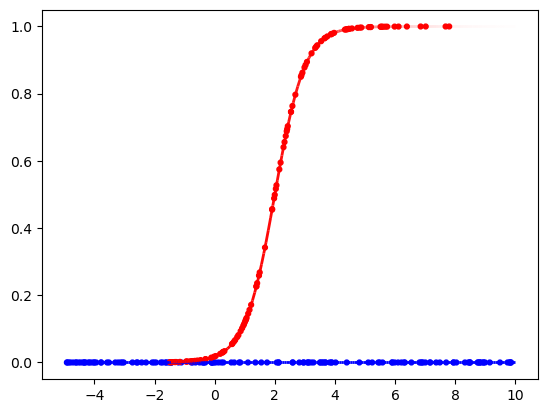

In [127]:
# Multi-branch data generator
mbgen = MultiBranchGenerator()
mbgen.add_branch(
    px_type='const', px_par={'c': 1, 'xmin': -5, 'xmax': 10},
    fy_type='const', fy_par={'c': 0}
)
mbgen.add_branch(
    #px_type='const', px_par={'c': 1},
    px_type='sigmoid', px_par={'c': 0, 'a': 1, 'x0': 5, 'k': -1,
                               'xmin': -1.5, 'xmax': 10}, 
    fy_type='sigmoid', fy_par={'c': 0, 'a': 1, 'x0': 2, 'k': 2},
    weight=0.8
)

# Generate points
P = mbgen.generate_points(256)

plt.figure()
x = np.linspace(-5, 10, 200)
mbgen.plot_branches(x)
P.plot(cvar='branch', s=12)
plt.show()

#### Training loop

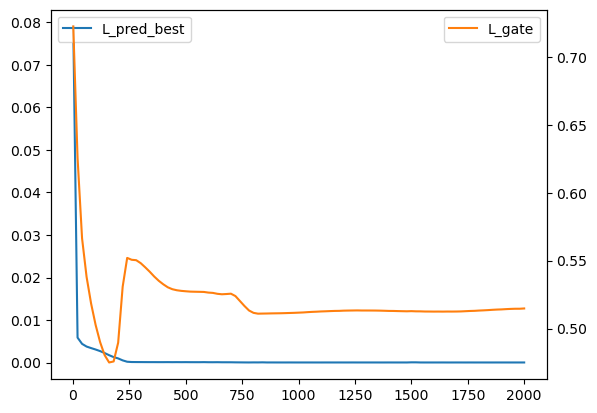

In [130]:
TORCH_SEED = 1
SPLIT_SEED = 0

HIDDEN_SZ = 16
NLAYERS_HID = 1
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 2000
PRINT_EVERY = 20

loss_params = {'gamma': 0.1, 'tau': 0.02, 'delta': 1e-2}

#torch.manual_seed(TORCH_SEED)

# Convert points data to tensors
Pt = P.to_torch(device).unsqueeze(dim=1)

# Define the model
n_feat = Pt['x'].shape[1]
n_out = Pt['y'].shape[1]
model = GatedKHeads(n_feat, n_out, HIDDEN_SZ, NLAYERS_HID, K=2)
model = model.to(device)

# Loader
dataset = torch.utils.data.TensorDataset(Pt['x'], Pt['y'])
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Loss function
loss_fn = lambda pred, y: loss_kheads(*pred, y, **loss_params)

# Progress tracker
pt = ProgressTracker()
pt.add_data('epoch', 'x')
for v in ['L_pred_best']:
    pt.add_data(v, 'y1')
for v in ['L_gate']:
    pt.add_data(v, 'y2')
for v in ['gate_bal', 'gate_ent']:
    #pt.add_data(v, 'y2')
    pt.add_data(v)

# Main loop
for epoch in range(1, EPOCHS + 1):
    model.train()

    train_loss = 0
    n_seen = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        pred = model(xb)
        loss, _ = loss_fn(pred, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        n_seen += xb.size(0)

    train_loss /= n_seen

    if epoch % PRINT_EVERY == 0 or epoch == 1:
    #if (epoch % PRINT_EVERY == 0) and (epoch > 70):
        model.eval()
        res = kheads_eval(model, Pt, **loss_params)
        pt.append('epoch', epoch)
        for v in res:
            if v in pt.data:
                pt.append(v, res[v])
        pt.plot()        
        clear_output(wait=True)
        display(pt.fig)

plt.close(pt.fig)

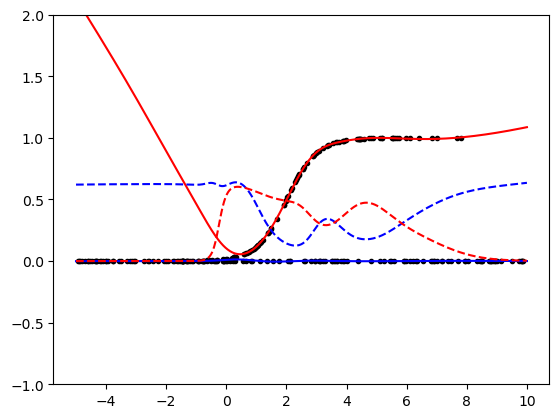

In [131]:
def eval_model(model, x: np.ndarray):
    x_tens = torch.from_numpy(x).float().unsqueeze(1)
    model.eval()
    with torch.no_grad():
        #y = model(x_tens).to('cpu').numpy()
        yK, pi, pi_logits = model(x_tens)
        yK = yK.to('cpu').numpy()
        pi = pi.to('cpu').numpy()
    return yK, pi, pi_logits

x_ = np.linspace(-5, 10, 1000)
yK_, pi_, pi_logits_ = eval_model(model, x_)

plt.figure()
plt.plot(P['x'], P['y'], 'k.')
plt.plot(x_, yK_[:, 0], 'b')
plt.plot(x_, yK_[:, 1], 'r')
plt.plot(x_, pi_[:, 0], 'b--')
plt.plot(x_, pi_[:, 1], 'r--')
plt.ylim(-1, 2)
plt.show()